In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import analysis.grouped_analysis as ga
from collections import defaultdict
import scipy.stats as stats
import utils.eval_funcs as eval_funcs
import numpy.random as rng
import string

In [3]:
ALPHABET = np.array(list(string.ascii_lowercase + ' '))


def generate_guess(n):
    return "".join(rng.choice(ALPHABET, size=n))

plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams["font.weight"] = "bold"
plot_cfg = {
    "tick_label_size" : 50,
    "xlabel_size" : 60,
    "ylabel_size" : 60,
    "border_size" : 6,
    "bar_border_size" : 2.5,
    "bar_label_size" : 32,
    "stars_label_size" : 48,
    "annot_size" : 72,
    "max_cm_classes" : 4,
    "legend_size" : 42,
    "max_bars" : 4
}

In [4]:
genes_to_complexes = ga.parse_yeast_complexes()
genes_to_pathways =  ga.parse_kegg_pathways()

In [5]:
genes_to_cp = defaultdict(lambda: { "complexes" : set(), "pathways" : set() })

for k, v in genes_to_complexes.items():
    genes_to_cp[k]["complexes"] = v 
        
for k,v in genes_to_pathways.items():
    genes_to_cp[k]["pathways"] = v 

In [6]:
group = 'complexes'

genes_to_groups = genes_to_complexes if group == 'complexes' else genes_to_pathways
all_groups = []
for k, v in genes_to_groups.items():
    all_groups.extend(v)
        

In [7]:
n_groups = len(set(all_groups))
print("No. groups: ", n_groups)
n_assoc = len(genes_to_groups)
print("No. Genes associated with a group: ", n_assoc)
genes_to_group = { g: list(v)[0] for g,v in genes_to_groups.items() if len(v) == 1}
n_one_pathway = len(genes_to_group)
print("No. Genes associated with only one group: ", n_one_pathway)
n_multiple_pathways = n_assoc - n_one_pathway
print("No. Genes removed due to involvement in multiple groups: ", n_multiple_pathways)

No. groups:  408
No. Genes associated with a group:  1627
No. Genes associated with only one group:  1416
No. Genes removed due to involvement in multiple groups:  211


In [8]:
tgi_task = pd.read_csv('../generated-data/task_yeast_tgi')
all_task_genes = set(tgi_task['a']) | set(tgi_task['b']) | set(tgi_task['c'])
for g in all_task_genes:
    if g not in genes_to_group:
        genes_to_group[g] = generate_guess(10)
print(len(genes_to_group))
print(tgi_task.shape)
tgi_task['a_group'] = [genes_to_group[e] for e in tgi_task['a']]
tgi_task['b_group'] = [genes_to_group[e] for e in tgi_task['b']]
tgi_task['c_group'] = [genes_to_group[e] for e in tgi_task['c']]

2249
(74463, 7)


In [9]:
ix_all = tgi_task['a'].isin(genes_to_group) & tgi_task['b'].isin(genes_to_group) & tgi_task['c'].isin(genes_to_group)

In [10]:
ix_two = (tgi_task['a'].isin(genes_to_group) & tgi_task['b'].isin(genes_to_group)) | (tgi_task['a'].isin(genes_to_group) & tgi_task['c'].isin(genes_to_group)) \
    | (tgi_task['b'].isin(genes_to_group) & tgi_task['c'].isin(genes_to_group))

In [11]:
ix_one = tgi_task['a'].isin(genes_to_group) | tgi_task['b'].isin(genes_to_group) | tgi_task['c'].isin(genes_to_group)

In [12]:
sel_tgi_df = tgi_task[ix_all]
print(np.sum(ix_all))

74463


In [13]:
R = np.zeros((2, 2))
for b in [0, 1]:
    ix_bin = sel_tgi_df['bin'] == b
    ix_all_members = (sel_tgi_df['a_group'] == sel_tgi_df['b_group']) & (sel_tgi_df['a_group'] == sel_tgi_df['c_group'])
    print(np.sum(ix_all_members))
    R[b, 0] = np.sum(ix_bin & ~ix_all_members)
    R[b, 1] = np.sum(ix_bin & ix_all_members)
R

7
7


array([[2.8330e+03, 2.0000e+00],
       [7.1623e+04, 5.0000e+00]])

[[2.8330e+03 2.0000e+00]
 [7.1623e+04 5.0000e+00]]
[[ 2835.]
 [71628.]]
[[7.4456e+04 7.0000e+00]]
[[2.83473349e+03 2.66508199e-01]
 [7.16212665e+04 6.73349180e+00]]
**
[[2.8330e+03 2.0000e+00]
 [7.1623e+04 5.0000e+00]]
11.72280504946237
0.008395623243940218


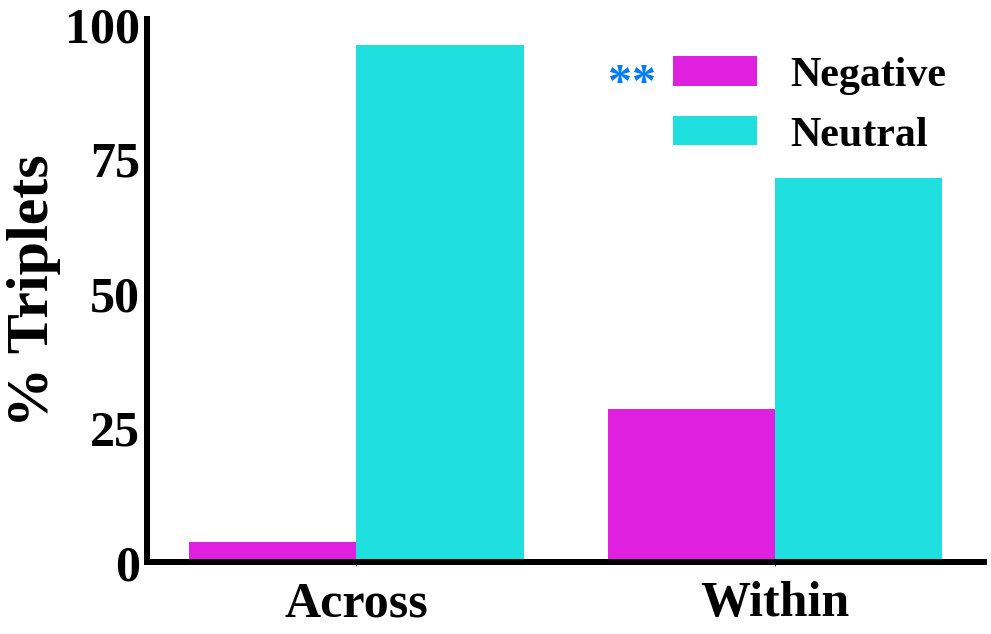

In [21]:

def chi2(f_obs):

    # compute expected frequencies
    col_marginal = np.sum(f_obs, axis=1, keepdims=True)
    row_marginal = np.sum(f_obs, axis=0, keepdims=True)
    total = np.sum(row_marginal)
    f_exp = np.dot(col_marginal / total, row_marginal)
    
    
    print(f_obs)
    print(col_marginal)
    print(row_marginal)
    print(f_exp)
    
    chisq, p = stats.chisquare(f_obs, f_exp, axis=None)
    
    ddof = (f_obs.shape[0]-1) * (f_obs.shape[1]-1)

    return chisq, p, ddof

def visualizeR(R, col_labels):
    star_colors = ['magenta', '#007bff']
    rows = []
    bin_labels = ['Negative', 'Neutral']
    for thebin in range(R.shape[0]):
        for j in range(R.shape[1]):
            rows.append({
                "bin" : bin_labels[thebin],
                "membership" : col_labels[j],
                "freq" : R[thebin, j] / np.sum(R[:, j]) 
            })
    
        for j in range(2 - R.shape[1]):
            rows.append({
                "bin" : bin_labels[thebin],
                "membership" : ' ' * (j+1),
                "freq" : 0
            })
    
    
    df = pd.DataFrame(rows)
    df['freq'] = df['freq'] * 100
    
    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    g = sns.barplot(x="membership", 
            y="freq", 
            hue="bin",
            ax=ax,
            data=df, 
            palette=['magenta', 'cyan'])
    
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'], pad=15)
    ax.set_xlabel("")
    ax.set_ylabel("% Triplets", fontsize=plot_cfg['ylabel_size'], weight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False, fontsize=plot_cfg['legend_size'])
    plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
    
    chisq, p, ddof = chi2(R)
    stars = '*' * eval_funcs.compute_stars(p, 0.05)
    print(stars)
    print(R)
    print(chisq)
    print(p)
    ax.text(0.55, 0.92, stars, 
                    transform=ax.transAxes,
                    color=star_colors[1], ha="left", va="top", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])
    #ax.set_title(title, fontsize=plot_cfg['xlabel_size'], fontweight='bold')
visualizeR(R, ['Across', 'Within'])